In [ ]:
library('dplyr')
library(plyr)
library(ggplot2)
#library(ImpulseDE2.extended)
library(BiocParallel)
register(MulticoreParam(workers = 30))

# To load all functions
library(Biobase)
#library(BiocParallel)
library(circlize)
import::from(compiler, cmpfun)
library(ComplexHeatmap)
import::from(cowplot, plot_grid)
library(DESeq2)
library(ggplot2)
import::from(grDevices, dev.off, graphics.off, pdf)
library(knitr)
library(Matrix)
library(methods)
import::from(stats, dnbinom, median, optim, p.adjust, pchisq, rnbinom, rnorm, runif, sd, time)
library(SummarizedExperiment)
import::from(utils, packageDescription)
import::from(zoo,as.zoo,rollapply)

sapply(list.files('/home/khrovatin/git/ImpulseDE2_extended/R', full.name=TRUE), source)

In [159]:
server=TRUE
if (server){
    pathSave='/home/khrovatin/timeTrajectoriesNet/data/stages/disagg/impulse/'
    pathCounts='/home/khrovatin/timeTrajectoriesNet/data/counts/'
    pathConditions='/home/khrovatin/timeTrajectoriesNet/data/RPKUM/'
}else{
    pathSave='/home/karin/Documents/timeTrajectories/data/stages/disagg/impulse/'
    pathCounts='/home/karin/Documents/timeTrajectories/data/countsRaw/combined/'
    pathConditions='/home/karin/Documents/timeTrajectories/data/RPKUM/combined/'
}

## Fit models

In [1135]:
genes<-read.table(paste(pathCounts,'mergedGenes_counts.tsv',sep=''), header=TRUE,row.names=1, sep="\t")
conditions<-read.table(paste(pathConditions,'conditions_mergedGenes.tsv',sep=''), header=TRUE,row.names='Measurment', sep="\t")
conditions[conditions=='']=NA
#R imported colnames of genes with changes but gene IDs remained ok
rownames(conditions)<-make.names(rownames(conditions))

### WT
Fit extended models on WT data without batch factors. Model is fitted to time-course of samples.

In [130]:
Y=conditions[conditions$Group=='WT', 'Time',drop=F]
Y[,'Sample']=rownames(Y)
Y[,'Condition']='case'

# Retain only times with more than 2 samples - AX4 has some reps 
# that have more time points and can affect model fitting
minNRep=2
sampleCount<-count(Y,'Time')
Y<- Y[Y$Time %in% sampleCount[sampleCount$freq>minNRep,'Time'],]

Y<-Y[order(Y$Time),]
X=genes[,Y$Sample]
print(dim(X))

[1] 12828    98


In [ ]:
objectImpulseDE2 <- runImpulseDE2(matCountData = as.matrix(X), dfAnnotation = Y,boolCaseCtrl = FALSE,
                                  vecConfounders = NULL,
                                  boolIdentifyTransients = TRUE,scaNProc = 40, boolExtended=TRUE)

saveRDS(object=objectImpulseDE2,file=paste(pathSave,'WT_min',minNRep,'Rep.rds',sep=''))

In [133]:
r<-objectImpulseDE2$dfImpulseDE2Results
r<-r[!r$allZero,]

In [1162]:
length(vecDispersions)

[1] 11981

In [ ]:
boolCaseCtrl=FALSE

for (strain in c('tgrB1','tgrB1C1','tgrC1','gbfA')){
    print(strain)
    Y=conditions[conditions$Strain==strain, c('Time','Replicate'),drop=F]
    colnames(Y)<-c('Time','Batch')
    Y[,'Sample']=rownames(Y)
    Y[,'Condition']='case'
    Y<-Y[order(Y$Time),]
    X=genes[,Y$Sample]
    print(dim(Y))
    
    # Estimate dispersion on strain data
    lsProcessedData <- processData(dfAnnotation = Y, matCountData = as.matrix(X), 
                boolCaseCtrl = boolCaseCtrl, vecConfounders = NULL,
                 vecDispersionsExternal = NULL, 
                vecSizeFactorsExternal = NULL)

    matCountDataProc <- lsProcessedData$matCountDataProc
    dfAnnotationProc <- lsProcessedData$dfAnnotationProc
    vecSizeFactorsExternalProc <- 
        lsProcessedData$vecSizeFactorsExternalProc
    vecDispersionsExternalProc <- 
        lsProcessedData$vecDispersionsExternalProc

    # Calculate dispersion on all replicates
    vecDispersions <- runDESeq2(
                        dfAnnotationProc = dfAnnotationProc, 
                        matCountDataProc = matCountDataProc, 
                        boolCaseCtrl = boolCaseCtrl, 
                        vecConfounders = NULL)
    #print(vecDispersions[1:3])
    
    # Fit models on each replicate
    replicates=unique(Y$Batch)
    print(replicates)
    for(replicate in replicates){
        print(replicate)
        Y=conditions[conditions$Replicate==replicate, c('Time'),drop=F]
        colnames(Y)<-c('Time')
        Y[,'Sample']=rownames(Y)
        Y[,'Condition']='case'
        Y<-Y[order(Y$Time),]
        # Use only genes for which dispersions were calculated
        X=genes[names(vecDispersions),Y$Sample]
        print(dim(Y))
        #print(rownames(X)[1:3])

        objectImpulseDE2<- runImpulseDE2 (
            matCountData = as.matrix(X), dfAnnotation = Y, boolCaseCtrl = boolCaseCtrl, 
            vecConfounders = NULL, scaNProc = 40, 
            vecDispersionsExternal = vecDispersions,  
            boolIdentifyTransients = TRUE,  boolExtended=TRUE) 
        saveRDS(object=objectImpulseDE2,file=paste(pathSave,replicate,'.rds',sep=''))
    }

}

In [ ]:
# Testing replicates of a disagg strain together
for(strain in c('tgrB1','tgrB1C1','tgrC1','gbfA')){
    print(strain)
    Y=conditions[conditions$Strain==strain, c('Time','Replicate'),drop=F]
    colnames(Y)<-c('Time','Batch')
    Y[,'Sample']=rownames(Y)
    Y[,'Condition']='case'
    Y<-Y[order(Y$Time),]
    X=genes[,Y$Sample]
    print(dim(Y))
    objectImpulseDE2 <- runImpulseDE2(matCountData = as.matrix(X), dfAnnotation = Y,boolCaseCtrl = FALSE,
                                  #vecConfounders = c('Batch'),
                                      vecConfounders = NULL,
                                  boolIdentifyTransients = TRUE,scaNProc = 40, boolExtended=TRUE)

    saveRDS(object=objectImpulseDE2,file=paste(pathSave,strain,'.rds',sep=''))
}

## Select models and genes

In [734]:
bestFits<-function(objectImpulseDE2,scaQThres=0.001){
    result<-objectImpulseDE2$dfImpulseDE2Results
    result<-result[!result$allZero,]
    
    # P values for the model
    isSignifSigmoid<-result$sigmoidTOconst_padj<=scaQThres
    isSignifImpulse<-(result$padj<=scaQThres & 
                  result$impulseTOsigmoid_padj<=scaQThres) 
    isSignifThreeSigmoid<-(result$threeSigmoidTOconst_padj<=scaQThres & 
                       result$threeSigmoidTOsigmoid_padj<=scaQThres &
                       result$threeSigmoidTOimpulse_padj<=scaQThres)
    isSignifFourSigmoid<-(result$fourSigmoidTOconst_padj<=scaQThres & 
                      result$fourSigmoidTOsigmoid_padj<=scaQThres &
                      result$fourSigmoidTOimpulse_padj<=scaQThres &
                      result$fourSigmoidTOthreeSigmoid_padj<=scaQThres)  
    
    # May be this model due to pvalues and shape (local min/max count)
    boolSigmoid<-(isSignifSigmoid |
                 (isSignifImpulse & result$NMinMax_impulse ==2) |
                 (isSignifThreeSigmoid & result$NMinMax_threeSigmoid ==2) |
                 (isSignifFourSigmoid & result$NMinMax_fourSigmoid ==2))
    boolImpulse<-((isSignifImpulse & result$NMinMax_impulse == 3) |
                 (isSignifThreeSigmoid & result$NMinMax_threeSigmoid ==3) |
                 (isSignifFourSigmoid & result$NMinMax_fourSigmoid ==3))
    boolThreeSigmoid<-((isSignifThreeSigmoid & result$NMinMax_threeSigmoid == 4) |
                      (isSignifFourSigmoid & result$NMinMax_fourSigmoid == 4))
    boolFourSigmoid<-(isSignifFourSigmoid & result$NMinMax_fourSigmoid == 5)
    
    # Assign most complex model that is better fitted than less compelx models
    boolModels<-data.frame('S1'=boolSigmoid,'S2'=boolImpulse,'S3'=boolThreeSigmoid,'S4'=boolFourSigmoid)
    rownames(boolModels)<-rownames(result)
    boolModels['main']<-apply(boolModels, 1,function(x){
                                trueModels<-which(as.vector(unlist(x)))
                                if(length(trueModels)>0){
                                    model=max(trueModels)
                                }else{
                                    model=0
                                }
                                return(model)
                                })
    # Best fit is largest still significant model (better than less complex models)
    boolModels['bestFit']<-as.vector(unlist(lapply(1:dim(boolModels)[1],function(idx){
        bestFit=0
        if(isSignifFourSigmoid[idx] & result$NMinMax_fourSigmoid[idx] == (boolModels[idx,'main']+1)){
            bestFit=4
        }else if(isSignifThreeSigmoid[idx] & result$NMinMax_threeSigmoid[idx] == (boolModels[idx,'main']+1)){
            bestFit=3
        }else if(isSignifImpulse[idx] & result$NMinMax_impulse[idx] == (boolModels[idx,'main']+1)){
            bestFit=2
        }else if(isSignifSigmoid[idx]){
            bestFit=1
        }
        return(bestFit)
    })))

    return(boolModels)
}

In [1173]:
filterByTransitions<-function(impulse1,impulse2,fits1,fits2, vecGeneIDs){
    selected<-t(as.data.frame(lapply(vecGeneIDs, function(gene) {
        data1<-findTransitionsPeaks(impulse1,fits1[gene,'bestFit'],gene)
        data2<-findTransitionsPeaks(impulse2,fits2[gene,'bestFit'],gene)
        firstTransition1<-min(data1$transitions)
        boolLateTransition<-sum(data1$transitions>firstTransition1)<sum(data2$transitions>firstTransition1)
        # First min or max
        if(min(data1$timesMin)<min(data1$timesMax)){
            start='timesMin'
        }else{
            start='timesMax'
        }
        data2StartTime=min(data2[[start]])
        data2MinMax<-union(data2$timesMin[data2$timesMin>=data2StartTime],
                           data2$timesMax[data2$timesMax>=data2StartTime])
        data1MinMax<-union(data1$timesMin,data1$timesMax)
        boolComplexShape<-length(data2MinMax)>length(data1MinMax)
        return(c(boolLateTransition, boolComplexShape))
    })))
    rownames(selected)<-vecGeneIDs
    colnames(selected)<-c('hasLateTransition','hasComplexShape')
    return(selected)
}

In [1822]:
findTransitionsPeaks<-function(impulse,model,gene){
    modelExtraction<-vector('list',4)
    modelExtraction[[1]]<-vector('list',3)
    modelExtraction[[1]][[1]]<-c('lsSigmoidFit')
    modelExtraction[[1]][[2]]<-c('vecSigmoidParam')
    modelExtraction[[1]][[3]]<-c('t')
    modelExtraction[[2]]<-vector('list',3)
    modelExtraction[[2]][[1]]<-c('lsImpulseFit')
    modelExtraction[[2]][[2]]<-c('vecImpulseParam')
    modelExtraction[[2]][[3]]<-c('t1','t2')
    modelExtraction[[3]]<-vector('list',3)
    modelExtraction[[3]][[1]]<-c('lsThreeSigmoidFit')
    modelExtraction[[3]][[2]]<-c('vecThreeSigmoidParam')
    modelExtraction[[3]][[3]]<-c('t1','t2','t3')
    modelExtraction[[4]]<-vector('list',3)
    modelExtraction[[4]][[1]]<-c('lsFourSigmoidFit')
    modelExtraction[[4]][[2]]<-c('vecFourSigmoidParam')
    modelExtraction[[4]][[3]]<-c('t1','t2','t3','t4')
    transitionTimes<-as.vector(unlist(impulse@lsModelFits$case[[gene]]
                            [[modelExtraction[[model]][[1]]]][[modelExtraction[[model]][[2]]]]
                            [modelExtraction[[model]][[3]]]))
    vecTimePointsCase <- sort(
      get_lsModelFits(obj = impulse)$IdxGroups$case$vecTimepointsUnique,decreasing = FALSE)

      vecValues<-getPredictedValues(impulse=impulse,gene=gene,model=model,
                                               vecTimePoints=vecTimePointsCase)
      vecValuesUnique<-vecValues[vecValues!=c(vecValues[-1], FALSE)]
      vecTimePointsValues<-vecTimePointsCase[vecValues!=c(vecValues[-1], FALSE)]
      if(length(vecValuesUnique)>1){
        left<-vecValuesUnique[2]
        right<-tail(vecValuesUnique,2)[1]
        vecValuesUnique <- c(left, vecValuesUnique, right)
        vecValuesUnique <- as.zoo(vecValuesUnique)
        boolMin<-rollapply(vecValuesUnique, 3, function(x) which.min(x) == 2 )
        boolMax<-rollapply(vecValuesUnique, 3, function(x)  which.max(x) == 2)
        #Rollaply here does not give result for border elements
        timesMinMax<-vecTimePointsValues[boolMin|boolMax]   
        transitions<-c()                 
        for(idx in 2:length(timesMinMax)){
            t1=timesMinMax[idx-1]
            t2=timesMinMax[idx]
            #So that t outside of times range are included
            if(idx==2) t1=-Inf
            if(idx==length(timesMinMax)) t2=Inf
            transition<-mean(transitionTimes[transitionTimes > t1 & transitionTimes < t2])
            #Quick fix if transition times in not between min/max
            #TODO remove quick fix
            if(is.nan(transition)) transition=mean(c(timesMinMax[idx-1],timesMinMax[idx]))
            transitions<-c(transitions,transition)
        }                
      }else{
          transitions=NULL
      }
                          
    return(list(transitions=transitions,
                timesMin=vecTimePointsValues[boolMin],timesMax=vecTimePointsValues[boolMax]))
}

In [1198]:
MODELS<-c('sigmoid','impulse','threeSigmoid','fourSigmoid')

In [1357]:
# Model that has smallest pvalue against constasnt for specified N min/max 
filterByFits<-function(result_ref,result_case,fits_ref,fits_case, vecGeneIDs){
    
    fitData<-t(as.data.frame(lapply(vecGeneIDs, function(gene) {
        fit_ref=fits_ref[gene,'main']
        fit_case=fits_case[gene,'main']
        padjs_ref<-extractPadjN(result_ref,gene)
        padjs_case<-extractPadjN(result_case,gene)
        
        ref_caseModel_padj_data<-minPadjN(padjs_ref,(fit_case+1))
        case_caseModel_padj_data<-minPadjN(padjs_case,(fit_case+1))
        case_refModel_padj_data<-minPadjN(padjs_case,(fit_ref+1))
        ref_refModel_padj_data<-minPadjN(padjs_ref,(fit_ref+1))
        
        ref_caseTObestModel_padj<-padjModels(result_ref,model2=ref_caseModel_padj_data[2],
                                                model1=fits_ref[gene,'bestFit'],gene)
        case_bestTOrefModel_padj<-padjModels(result_case,model2=fits_case[gene,'bestFit'],
                                                model1=case_refModel_padj_data[2],gene)
        
        return(c(
            ref_caseModel_padj_data[1], case_caseModel_padj_data[1], ref_caseTObestModel_padj,
            case_refModel_padj_data[1], ref_refModel_padj_data[1], case_bestTOrefModel_padj
        ))
        
    })))
    rownames(fitData)<-vecGeneIDs
    colnames(fitData)<-c('ref_caseModel_padj','case_caseModel_padj','ref_caseTObestModel_padj',
                        'case_refModel_padj','ref_refModel_padj','case_bestTOrefModel_padj')
    return(as.data.frame(fitData))
}

In [1299]:
#Try out filterByFits function
#Data
result_ref<-result_WT
result_case<-result_gbfA
fits_ref<-fits_WT
fits_case<-fits_gbfA
gene='DDB_G0293216'

#Display gene info
fits_ref[gene,]
unlist(result_ref[gene,])
fits_case[gene,]
unlist(result_case[gene,])

#Get fit data
fit_ref=fits_ref[gene,'main']
fit_case=fits_case[gene,'main']
padjs_ref<-extractPadjN(result_ref,gene)
padjs_case<-extractPadjN(result_case,gene)

ref_caseModel_padj_data<-minPadjN(padjs_ref,(fit_case+1))
case_caseModel_padj_data<-minPadjN(padjs_case,(fit_case+1))
case_refModel_padj_data<-minPadjN(padjs_case,(fit_ref+1))
ref_refModel_padj_data<-minPadjN(padjs_ref,(fit_ref+1))

ref_caseTObestModel_padj<-padjModels(result_ref,model2=ref_caseModel_padj_data[2],
                                        model1=fits_ref[gene,'bestFit'],gene)
case_bestTOrefModel_padj<-padjModels(result_case,model2=fits_case[gene,'bestFit'],
                                        model1=case_refModel_padj_data[2],gene)
        
#Display fit data parsing results
fit_ref
fit_case
padjs_ref
padjs_case
ref_caseModel_padj_data
case_caseModel_padj_data
case_refModel_padj_data
ref_refModel_padj_data
ref_caseTObestModel_padj
case_bestTOrefModel_padj
fits_ref[gene,'bestFit']
fits_case[gene,'bestFit']

In [1257]:
# Model NMinMax and padj against constant
extractPadjN<-function(result,gene){
    modelData<-t(as.data.frame(lapply(MODELS, function(model) {
        padj<-result[gene,paste(model,'TOconst_padj',sep='')]
        if(model == 'sigmoid'){
            # This assumes nMinMax of sigmoid to be 2, although it could also be 0 (not computed)
            # (but in this case the pvalue compared to const would be high)
            nMinMax=2
        }else{
            nMinMax=result[gene,paste('NMinMax_',model,sep='')]
        }
        return(c(padj,nMinMax))
        })))
    colnames(modelData)<-c('const_padj','nMinMax')
    rownames(modelData)<-MODELS
    return(as.data.frame(modelData))
}

In [1293]:
minPadjN<-function(padj_data,nMinMax){
    padj_data<-padj_data[padj_data$nMinMax==nMinMax,]
    padj_data<-padj_data[order(padj_data$const_padj),]
    if(nrow(padj_data)<1){
        padj=NA
        model=NA
    }else{
        padj=padj_data$const_padj[1]
        model=which(MODELS==rownames(padj_data)[1])
    }
    return(c(padj,model))
}

In [1358]:
padjModels<-function(result,model1,model2,gene){
    # Not constant
    if(!is.na(model1) & !is.na(model2) & model1 < model2 ){
        model1<-MODELS[model1]
        model2<-MODELS[model2]
        padj<-result[gene,paste(model2,'TO',model1,'_padj',sep='')]
    }else{
        padj=NA
    }
    return(padj)
}

In [1842]:
nLargeDiff<-function(impulseRef,impulseCase,fitsRef,fitsCase, vecGeneIDs,diffThreshold=0.1){
    vecTimePointsRef <- sort(get_lsModelFits(obj = impulseRef)$IdxGroups$case$vecTimepointsUnique,
        decreasing = FALSE)
    vecTimePointsCase <- sort(get_lsModelFits(obj = impulseCase)$IdxGroups$case$vecTimepointsUnique,
        decreasing = FALSE)
    nLargeDiff<-t(as.data.frame(lapply(vecGeneIDs, function(gene){
        fitRef<-fitsRef[gene,'bestFit']
        fitCase<-fitsCase[gene,'bestFit']
        valuesRef<-getPredictedValues(impulse=impulseRef,gene=gene,model=fitRef,
                                      vecTimePointsCase=vecTimePointsRef) 
        rangeRef<-max(valuesRef)-min(valuesRef)
        differencesRefNorm<-minMaxDiff(vecValues=valuesRef)/rangeRef
        valuesCase<-getPredictedValues(impulse=impulseCase,gene=gene,model=fitCase,
                                      vecTimePoints=vecTimePointsCase) 
        differencesCaseNorm<-minMaxDiff(vecValues=valuesCase)/rangeRef
        nLargeDiffRef<-sum(differencesRefNorm >= diffThreshold)
        nLargeDiffCase<-sum(differencesCaseNorm >= diffThreshold)
        return(c(nLargeDiffRef,nLargeDiffCase))
    })))
    colnames(nLargeDiff)<-c('nLargeDiffRef','nLargeDiffCase')
    rownames(nLargeDiff)<-vecGeneIDs
    return(nLargeDiff)
}

In [1787]:
getPredictedValues<-function(impulse,gene,model,vecTimePoints){
     fit<-get_lsModelFits(obj = impulse)$case[[gene]]
     if (model == 1) {
        vecValues <- evalSigmoid_comp(
          vecSigmoidParam = fit$lsSigmoidFit$vecSigmoidParam,
          vecTimepoints = vecTimePoints)
      }else if (model == 2) {
        vecValues <- evalImpulse_comp(
          vecImpulseParam = fit$lsImpulseFit$vecImpulseParam,
          vecTimepoints = vecTimePoints)
      }else if (model == 3) {
        vecValues <- evalThreeSigmoid_comp(
          vecThreeSigmoidParam = fit$lsThreeSigmoidFit$vecThreeSigmoidParam,
          vecTimepoints = vecTimePoints)
      } else if (model == 4) {
        vecValues <- evalFourSigmoid_comp(
          vecFourSigmoidParam = fit$lsFourSigmoidFit$vecFourSigmoidParam,
          vecTimepoints = vecTimePoints)
      }
      vecValues<-as.vector(as.integer(vecValues))
      return(vecValues)
}

In [1820]:
minMaxDiff<-function(vecValues){
      vecValuesUnique<-vecValues[vecValues!=c(vecValues[-1], FALSE)]
      if(length(vecValuesUnique)>1){
        left<-vecValuesUnique[2]
        right<-tail(vecValuesUnique,2)[1]
        vecValuesUniquePadded <- c(left, vecValuesUnique, right)
        vecValuesUniquePadded <- as.zoo(vecValuesUniquePadded)
        boolMinMax<-rollapply(vecValuesUniquePadded, 3, function(x) which.min(x) == 2 | which.max(x) == 2) 
        #Rollaply here does not give result for border elements
        vecValuesMinMax<-vecValuesUnique[boolMinMax] 
        nMinMax<-length(vecValuesMinMax)                      
        differences<-abs(tail(vecValuesMinMax,nMinMax-1)-head(vecValuesMinMax,nMinMax-1))             
      }else{
          differences=c()
      }
      return(differences)
}

### Select genes

In [1686]:
impulse_ref<-readRDS(file=paste(pathSave,'WT_min2Rep','.rds',sep=''))

In [1889]:
caseStrain='gbfA'
doReps=FALSE
impulse_case<-readRDS(file=paste(pathSave,caseStrain,'.rds',sep=''))
if(doReps){
impulse_case_r1<-readRDS(file=paste(pathSave,caseStrain,'_r1','.rds',sep=''))
impulse_case_r2<-readRDS(file=paste(pathSave,caseStrain,'_r2','.rds',sep=''))
}

In [1890]:
fits_ref<-bestFits(impulse_WT,0.01)

fits_case<-bestFits(impulse_case,0.01)
bothGenes<-intersect(rownames(fits_ref[fits_ref$main>0,]),rownames(fits_case[fits_case$main>0 ,]))
vecPlotGenes<-bothGenes[fits_ref[bothGenes,]$main<fits_case[bothGenes,]$main]
fits_case_r1<-bestFits(impulse_case_r1,0.01)
print(length(vecPlotGenes))
if(doReps){
bothGenes_r1<-intersect(rownames(fits_ref[fits_ref$main>0,]),rownames(fits_case_r1[fits_case_r1$main>0 ,]))
vecPlotGenes_r1<-bothGenes_r1[fits_ref[bothGenes_r1,]$main<fits_case_r1[bothGenes_r1,]$main]
fits_case_r2<-bestFits(impulse_case_r2,0.01)
bothGenes_r2<-intersect(rownames(fits_ref[fits_ref$main>0,]),rownames(fits_case_r2[fits_case_r2$main>0 ,]))
vecPlotGenes_r2<-bothGenes_r2[fits_ref[bothGenes_r2,]$main<fits_case_r2[bothGenes_r2,]$main]
vecPlotGenes_r12<-intersect(vecPlotGenes_r1,vecPlotGenes_r2)
print(paste(length(vecPlotGenes_r1),length(vecPlotGenes_r2),length(vecPlotGenes_r12)))
}

result_ref<-impulse_ref$dfImpulseDE2Results
result_ref<-result_ref[!result_WT$allZero,]
result_case<-impulse_case$dfImpulseDE2Results
result_case<-result_case[!result_case$allZero,]
names(result_ref)[names(result_ref) == 'p'] <- 'impulseTOconst_p'
names(result_ref)[names(result_ref) == 'padj'] <- 'impulseTOconst_padj'
names(result_case)[names(result_case) == 'p'] <- 'impulseTOconst_p'
names(result_case)[names(result_case) == 'padj'] <- 'impulseTOconst_padj'

[1] 98


In [1891]:
filterTransitions<-filterByTransitions(impulse_ref,impulse_case,fits_ref,fits_case,vecPlotGenes)

In [1892]:
filterFits<-filterByFits(result_ref=result_ref,result_case=result_case,
                         fits_ref=fits_ref,fits_case=fits_case, vecGeneIDs=vecPlotGenes)

In [1893]:
filterNLargeDiff<-nLargeDiff(impulseRef=impulse_ref,impulseCase=impulse_case,
                             fitsRef=fits_ref,fitsCase=fits_case, vecGeneIDs=vecPlotGenes,diffThreshold=0.1)

### Analyse selected genes

In [1927]:
vecPlotGenesSub<-vecPlotGenes[!filterTransitions[,'hasComplexShape']]
length(vecPlotGenesSub)

[1] 26

In [1955]:
sum(filterNLargeDiff[,'nLargeDiffRef']<filterNLargeDiff[,'nLargeDiffCase'] & filterTransitions[,'hasComplexShape'])

[1] 5

               S1   S2    S3    S4 main bestFit
DDB_G0281979 TRUE TRUE FALSE FALSE    2       3
                S1    S2   S3    S4 main bestFit
DDB_G0281979 FALSE FALSE TRUE FALSE    3       3


hasLateTransition   hasComplexShape 
             TRUE              TRUE

nLargeDiffRef nLargeDiffCase 
             2              3

[1] "Setting boolSimplePlot=TRUE as no batch structure was found."
[1] "Setting boolSimplePlot=TRUE as no batch structure was found."


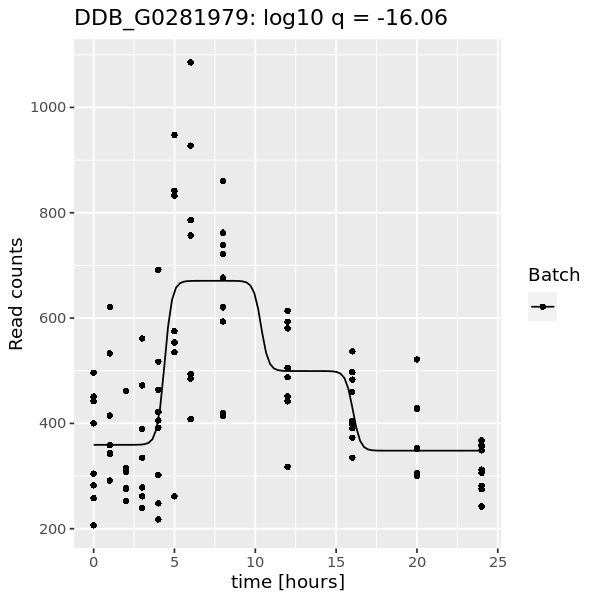

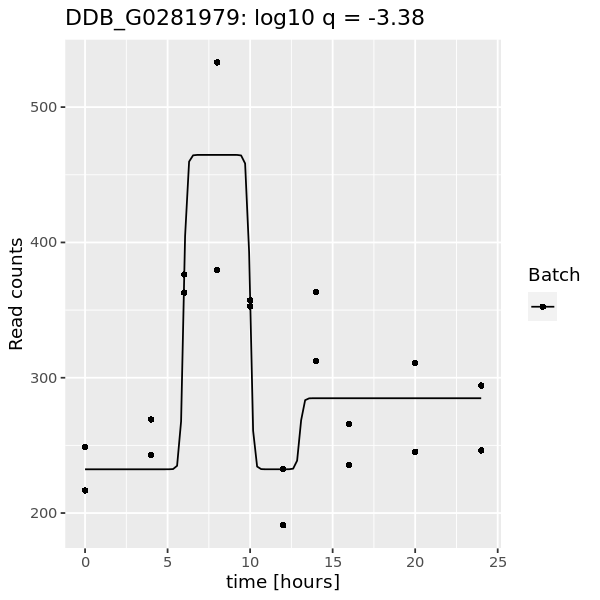

In [1965]:
idx=27
#gene=vecPlotGenesSub[idx]
gene='DDB_G0281979'
print(fits_ref[gene,])
print(fits_case[gene,])

#findTransitions(impulse_ref,fits_ref[gene,'bestFit'],gene)
#findTransitions(impulse_case,fits_case[gene,'bestFit'],gene)
filterTransitions[gene,]
#filterFits[gene,]
filterNLargeDiff[gene,]

plotGenesExtended(
vecGeneIDs = c(gene),
scaNTopIDs = NULL,
objectImpulseDE2 = impulse_ref,
boolCaseCtrl = FALSE,
dirOut = NULL,
strFileName = NULL,
vecRefPval = NULL,
strNameRefMethod = NULL,model=MODELS[fits_ref[gene,'bestFit']])[[1]]
plotGenesExtended(
vecGeneIDs =c(gene),
scaNTopIDs = NULL,
objectImpulseDE2 = impulse_case,
boolCaseCtrl = FALSE,
dirOut = NULL,
strFileName = NULL,
vecRefPval = NULL,
strNameRefMethod = NULL,model=MODELS[fits_case[gene,'bestFit']])[[1]]

In [1635]:
unlist(result_WT[vecPlotGenesSub[idx],])
unlist(result_gbfA[vecPlotGenesSub[idx],])

Gene               impulseTOconst_p 
                "DDB_G0269712"         "6.34752925722208e-06" 
           impulseTOconst_padj                    loglik_full 
        "1.25880433294717e-05"            "-711.326337294809" 
                    loglik_red                        df_full 
           "-727.253788696874"                            "7" 
                        df_red                           mean 
                           "2"             "642.002018922485" 
              converge_impulse                 converge_const 
                           "0"                            "0" 
              converge_sigmoid             impulseTOsigmoid_p 
                           "0"                            "1" 
         impulseTOsigmoid_padj               sigmoidTOconst_p 
                           "1"         "1.18168209289894e-09" 
           sigmoidTOconst_padj                    isTransient 
        "1.96989546894248e-09"                        "FALSE" 
                  isMonotonous          converge_threeSigmoid 
                        "TRUE"                            "0" 
          converge_fourSigmoid          threeSigmoidTOconst_p 
                           "0"         "8.37180318897371e-09" 
      threeSigmoidTOconst_padj        threeSigmoidTOsigmoid_p 
        "1.29460549877318e-08"            "0.152313282704072" 
    threeSigmoidTOsigmoid_padj        threeSigmoidTOimpulse_p 
           "0.295557164914059"         "6.28239145117407e-05" 
    threeSigmoidTOimpulse_padj           fourSigmoidTOconst_p 
         "0.00013745583137901"         "6.41090660539189e-08" 
       fourSigmoidTOconst_padj         fourSigmoidTOsigmoid_p 
        "1.05673438520212e-07"            "0.349824498467031" 
     fourSigmoidTOsigmoid_padj         fourSigmoidTOimpulse_p 
           "0.621034461149643"         "0.000673284032026605" 
     fourSigmoidTOimpulse_padj    fourSigmoidTOthreeSigmoid_p 
         "0.00141088073966077"                            "1" 
fourSigmoidTOthreeSigmoid_padj                NMinMax_impulse 
                           "1"                            "3" 
          NMinMax_threeSigmoid            NMinMax_fourSigmoid 
                           "4"                            "4" 
                       allZero 
                       "FALSE"

Gene               impulseTOconst_p 
                "DDB_G0269712"                            "1" 
           impulseTOconst_padj                    loglik_full 
                           "1"            "-137.065439208958" 
                    loglik_red                        df_full 
           "-136.171529237249"                            "7" 
                        df_red                           mean 
                           "2"             "461.199101358975" 
              converge_impulse                 converge_const 
                           "0"                            "0" 
              converge_sigmoid             impulseTOsigmoid_p 
                           "0"                            "1" 
         impulseTOsigmoid_padj               sigmoidTOconst_p 
                           "1"           "0.0926064789286601" 
           sigmoidTOconst_padj                    isTransient 
           "0.215103336637927"                        "FALSE" 
                  isMonotonous          converge_threeSigmoid 
                       "FALSE"                            "0" 
          converge_fourSigmoid          threeSigmoidTOconst_p 
                           "0"            "0.024283915647287" 
      threeSigmoidTOconst_padj        threeSigmoidTOsigmoid_p 
          "0.0890583149981982"           "0.0464444921825592" 
    threeSigmoidTOsigmoid_padj        threeSigmoidTOimpulse_p 
           "0.612727924237095"         "0.000131015210650829" 
    threeSigmoidTOimpulse_padj           fourSigmoidTOconst_p 
          "0.0004625560521744"            "0.047421597019399" 
       fourSigmoidTOconst_padj         fourSigmoidTOsigmoid_p 
           "0.186667011660785"           "0.0995676003931046" 
     fourSigmoidTOsigmoid_padj         fourSigmoidTOimpulse_p 
                           "1"         "0.000832971009034146" 
     fourSigmoidTOimpulse_padj    fourSigmoidTOthreeSigmoid_p 
         "0.00288076131987694"            "0.609234572348514" 
fourSigmoidTOthreeSigmoid_padj                NMinMax_impulse 
                           "1"                            "2" 
          NMinMax_threeSigmoid            NMinMax_fourSigmoid 
                           "3"                            "4" 
                       allZero 
                       "FALSE"

In [755]:
impulse_ref@lsModelFits$case[['DDB_G0267382']][[modelExtraction[[4]][1]]][[modelExtraction[[4]][2]]]
impulse_case@lsModelFits$case[[plotGenes[idx]]][[modelExtraction[[3]][1]]][[modelExtraction[[3]][2]]]

beta           h0           h1           h2           h3           h4 
2.923103e+00 1.019656e+03 2.342669e+04 3.316509e+04 1.446623e+04 8.128093e+03 
          t1           t2           t3           t4 
3.143891e-01 3.122086e-01 6.331168e+00 8.655668e+00

beta           h0           h1           h2           h3           t1 
  6.12249749   0.01200027  60.83255954  22.69206866 961.65411712   2.23924639 
          t2           t3 
  6.23416940  20.29800463

[1] "Setting boolSimplePlot=TRUE as no batch structure was found."


[[1]]


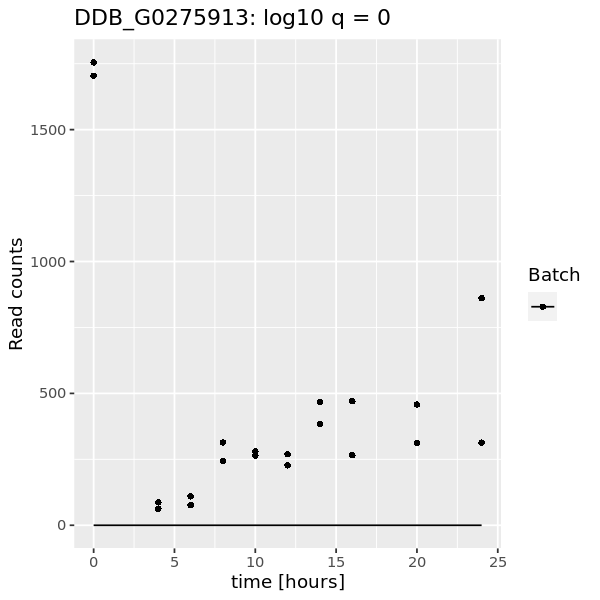

In [1730]:
plotGenesExtended(
vecGeneIDs =c('DDB_G0275913'),
scaNTopIDs = NULL,
objectImpulseDE2 = impulse_case,
boolCaseCtrl = FALSE,
dirOut = NULL,
strFileName = NULL,
vecRefPval = NULL,
strNameRefMethod = NULL,model='impulse')

In [1723]:
impulse_case@lsModelFits$case[['DDB_G0275913']][[unlist(modelExtraction[[1]][1])]]

$vecSigmoidParam
        beta           h0           h1            t 
   3.3523550 2154.0415313  303.5671246    0.3610832 

$vecSigmoidValue
  gbfA_0h_r1_28_S79_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                    1729.1424 
 gbfA_r3_00h_1_S126_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                    1729.1424 
  gbfA_4h_r1_29_S80_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                     303.5764 
 gbfA_r3_04h_2_S127_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                     303.5764 
  gbfA_6h_r1_30_S81_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                     303.5671 
 gbfA_r3_06h_3_S128_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                     303.5671 
  gbfA_8h_r1_31_S82_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                     303.5671 
 gbfA_r3_08h_4_S129_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                     303.5671 
 gbfA_10h_r1_32_S83_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                     303.5671 
 gbfA_r3_10h_5_S130_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                     303.5671 
 gbfA_12h_r1_33_S84_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                     303.5671 
 gbfA_r3_12h_6_S131_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                     303.5671 
 gbfA_14h_r1_34_S85_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                     303.5671 
gbfA_r3_14h_10_S135_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                     303.5671 
 gbfA_16h_r1_35_S86_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                     303.5671 
gbfA_r3_16h_11_S136_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                     303.5671 
 gbfA_20h_r1_36_S87_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                     303.5671 
gbfA_r3_20h_12_S137_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                     303.5671 
 gbfA_24h_r1_37_S88_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                     303.5671 
gbfA_r3_24h_13_S138_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff 
                                                                     303.5671 

$lsvecBatchFactors
NULL

$scaDispParam
DDB_G0275913 
    10.87981 

$scaLL
[1] -146.4266

$scaConvergence
[1] 0

In [1709]:
# Try to implement a simpler gene selection based on the sum of differences between neighbouring samples
absDiff<-function(vec){
    diff=abs(head(vec,length(vec)-1)-tail(vec,length(vec)-1))
    return(diff)
}

# Example gene expression profiles
examples=list('rising'=c(0,0,3,3,3,3), 'noisy'=c(0,3,0,3,0,3),
              'peak'=c(0,0,3,3,3,0,0),'small narrow peak'=c(0,0,1,1,0,0),
              'narrow peak'=c(0,0,3,3,0,0))
for (example_name in names(examples)){
    example=examples[[example_name]]
    # Calculate absolute differences between the time points and normalise by standard deviation (biased)
    exampleSd<-sd(example)*sqrt((length(example)-1)/length(example))
    normDiff<-rollapply(example, 2, absDiff)/exampleSd
    # Sum of normalised differences
    print(paste(example_name,': sum of normalised differences',round(sum(normDiff),2),
                '; normalised differences',paste(round(normDiff,2),collapse=', ')))
}

[1] "rising : sum of normalised differences 2.12 ; normalised differences 0, 2.12, 0, 0, 0"
[1] "noisy : sum of normalised differences 10 ; normalised differences 2, 2, 2, 2, 2"
[1] "peak : sum of normalised differences 4.04 ; normalised differences 0, 2.02, 0, 0, 2.02, 0"
[1] "small narrow peak : sum of normalised differences 4.24 ; normalised differences 0, 2.12, 0, 2.12, 0"
[1] "narrow peak : sum of normalised differences 4.24 ; normalised differences 0, 2.12, 0, 2.12, 0"


In [1618]:
plots_ref<-plotGenesExtended(
vecGeneIDs = vecPlotGenesSub[1:10],
scaNTopIDs = NULL,
objectImpulseDE2 = impulse_ref,
boolCaseCtrl = FALSE,
dirOut = NULL,
strFileName = NULL,
vecRefPval = NULL,
strNameRefMethod = NULL,model='fourSigmoid')
plots_case<-plotGenesExtended(
vecGeneIDs =vecPlotGenesSub,
scaNTopIDs = NULL,
objectImpulseDE2 = impulse_case,
boolCaseCtrl = FALSE,
dirOut = NULL,
strFileName = NULL,
vecRefPval = NULL,
strNameRefMethod = NULL,model='fourSigmoid')

[1] "Setting boolSimplePlot=TRUE as no batch structure was found."
[1] "Setting boolSimplePlot=TRUE as no batch structure was found."


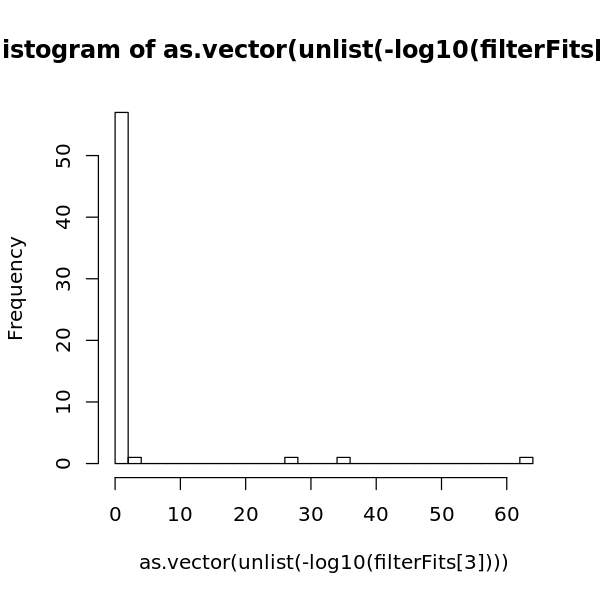

In [1344]:
hist(as.vector(unlist(-log10(filterFits[3]))),breaks =40)

In [1345]:
sum(is.na(as.vector(unlist(-log10(filterFits[3])))))

[1] 37

In [284]:
unlist(as.vector((df[1,])))

S1    S2    S3    S4 
FALSE FALSE FALSE FALSE

In [256]:
sum(result$isMonotonous)

[1] 8898

In [265]:
sum(boolFourSigmoid)

[1] 40

In [254]:
sum((result$padj<=scaQThres & result$impulseTOsigmoid_padj<=scaQThres & result$NMinMax_impulse ==3))

[1] 791

In [228]:
sum((result$fourSigmoidTOconst_padj<=scaQThres & 
                      result$fourSigmoidTOsigmoid_padj<=scaQThres &
                      result$fourSigmoidTOimpulse_padj<=scaQThres &
                      result$fourSigmoidTOthreeSigmoid_padj<=scaQThres &
                      result$NMinMax_fourSigmoid == 5))

[1] 40

In [223]:
colnames(r)

[1] "Gene"                           "p"                             
 [3] "padj"                           "loglik_full"                   
 [5] "loglik_red"                     "df_full"                       
 [7] "df_red"                         "mean"                          
 [9] "converge_impulse"               "converge_const"                
[11] "converge_sigmoid"               "impulseTOsigmoid_p"            
[13] "impulseTOsigmoid_padj"          "sigmoidTOconst_p"              
[15] "sigmoidTOconst_padj"            "isTransient"                   
[17] "isMonotonous"                   "converge_threeSigmoid"         
[19] "converge_fourSigmoid"           "threeSigmoidTOconst_p"         
[21] "threeSigmoidTOconst_padj"       "threeSigmoidTOsigmoid_p"       
[23] "threeSigmoidTOsigmoid_padj"     "threeSigmoidTOimpulse_p"       
[25] "threeSigmoidTOimpulse_padj"     "fourSigmoidTOconst_p"          
[27] "fourSigmoidTOconst_padj"        "fourSigmoidTOsigmoid_p"        
[29] "fourSigmoidTOsigmoid_padj"      "fourSigmoidTOimpulse_p"        
[31] "fourSigmoidTOimpulse_padj"      "fourSigmoidTOthreeSigmoid_p"   
[33] "fourSigmoidTOthreeSigmoid_padj" "NMinMax_impulse"               
[35] "NMinMax_threeSigmoid"           "NMinMax_fourSigmoid"           
[37] "allZero"

In [506]:
library(ComplexHeatmap)
library(circlize)
library(viridis)
library(proxy)
library(seriation)
library(dendextend)
library(dplyr)

In [476]:
path_expression='/home/khrovatin/timeTrajectoriesNet/data/regulons/'
path_strain_order='/home/khrovatin/timeTrajectoriesNet/data/'
path_phenotypes = '/home/khrovatin/timeTrajectoriesNet/data/stages/'

In [477]:
#**! Specify file names for regulons and expression
#** Expression tab file: Genes in columns (already scaled), averaged strain data in rows, 
#** three additional comlumns: Time, Strain, and Group (meaning strain group)
avg_expression=read.table(paste(path_expression,"genes_averaged_orange_scale99percentileMax0.1.tsv",sep=''),
                          header=TRUE,row.names=1, sep="\t")

#**! Specify file names for phenotipic data
#** Phenotypes tab file: Short averaged sample names in rows (as in avg_expression) and columns with phenotypes.
#** Phenotypes should have values: yes, no, no data
avg_phenotype=read.table(paste(path_phenotypes,"averageStages.tsv",sep=''),
                          header=TRUE,row.names=1, sep="\t", stringsAsFactors=FALSE)
#Change avg_phenotypes data so that each phenotype can be coloured differently
avg_phenotype[avg_phenotype=='no']=NA
for(col in colnames(avg_phenotype)){
  new_col=avg_phenotype[col]
  new_col[new_col=='yes']=col
  avg_phenotype[col]=new_col
}


#** Strain order - single column with ordered strain names
strain_order<-as.vector(read.table(paste(path_strain_order,"strain_order.tsv",sep=''))[,1])

In [478]:
#** Some plotting parameters
legend_font=12
phenotypes_font=10
legened_height=1.5
legend_width=0.7
top_annotation_height=0.6
phenotype_annotation_height=3
cluster_font=20

In [491]:
make_anno<-function(){



#Strain groups annotation
#** Colours of strain groups
group_cols=c('agg-'= '#ed1c24', 'lag_dis'= '#f97402','tag_dis'='#ffb100', 'tag'='#d9d800', 'cud'= '#008629', 'WT'= '#00b2ff',
                        'sFB'= '#1925ae', 'prec'='#a400d4' )
#group_cols_background=c('agg-'= '#cccccc', 'lag_dis'= '#666666','tag_dis'='#666666', 'tag'='#666666', 'cud'= '#cccccc', 
#                        'WT'= '#cccccc','sFB'= '#cccccc', 'prec'='#cccccc' )
group_cols_background=c('agg-'= 'white', 'lag_dis'= 'white','tag_dis'='#666666', 'tag'='#666666', 'cud'= 'white', 
                        'WT'= 'white','sFB'= 'white', 'prec'='white' )
group_cols_text=c('agg-'= 'black', 'lag_dis'= 'black','tag_dis'='black', 'tag'='black', 'cud'= '#eeeeee', 
                        'WT'= 'black','sFB'= '#eeeeee', 'prec'='#eeeeee' )

group_data=t(avg_expression['Group'])
rownames(group_data)<-c('Phenotypic group')            
# ht_list=Heatmap(group_data,show_column_names = FALSE, 
#                 height = unit(top_annotation_height, "cm"),
#                 column_split=factor(avg_expression$Strain,
#                                     #** Ordering of the strains in the heatmap (a vector of strain names)
#                                     #levels=unique(avg_expression$Strain)
#                                     levels=strain_order
#                 ),
#                 cluster_columns=FALSE,name='\nPhenotypic \ngroup\n',
#                 #** Strain name font size
#                 column_title_gp=gpar(fontsize=legend_font),
#                 col=group_cols, heatmap_legend_param = list( 
#                 grid_width= unit(legend_width, "cm"),grid_height= unit(legened_height, "cm") ,
#                 labels_gp = gpar(fontsize = cluster_font),title_gp = gpar(fontsize = cluster_font)),
#                 row_names_gp = gpar(fontsize = cluster_font))

#Time annotation
times=unique(avg_expression$Time)
#** Time colours, group colours, and gaps
group_cols_ordered=c()
groups_ordered=c()
background_cols_ordered=c()
text_cols_ordered=c()
gaps=c()
previous_group=NULL
for(strain in strain_order){
  group=as.character(avg_expression[avg_expression$Strain==strain,'Group'][1])
  #print(paste(strain,group,group_cols[group]))
  groups_ordered<-append(groups_ordered,group)
  group_cols_ordered<-append(group_cols_ordered,group_cols[group])
  background_cols_ordered<-append(background_cols_ordered,group_cols_background[group])
  text_cols_ordered<-append(text_cols_ordered,group_cols_text[group])
  #Gaps - if previous group was different add larger gap; (N gaps = N-1 columns)
  if (!is.null(previous_group)){
    if (previous_group==group){ 
      gaps=append(gaps,1)
    }else{
      gaps=append(gaps,2.5)
    }
  }
  previous_group=group
}
gaps=unit(gaps,'mm')

col_time = colorRamp2( c(min(times),max(times)),c( "white", "#440154FF"))

ht_list=Heatmap(t(avg_expression['Time']), height = unit(top_annotation_height, "cm"),
                column_split=factor(avg_expression$Strain,
                #** Ordering of the strains in the heatmap (a vector of strain names)
                levels=strain_order ),
                column_title =NULL,column_gap=gaps,
                cluster_columns=FALSE, show_column_names = FALSE,name='\nTime\n',col=col_time,
                heatmap_legend_param = 
                list( at = c(min(times),as.integer(mean(c(min(times),max(times)))),max(times)),
                grid_width= unit(legend_width, "cm"),grid_height= unit(legened_height, "cm") ,
                labels_gp = gpar(fontsize = cluster_font),title_gp = gpar(fontsize = cluster_font)
                    ),
                row_names_gp = gpar(fontsize = cluster_font),
                #column_title_gp=gpar(border =group_cols_ordered,fontsize=cluster_font,col =text_cols_ordered,fill=group_cols_ordered,
                #                     fontface='bold'),
                #Annotation for Phenotype group
                top_annotation = HeatmapAnnotation(
                  Phenotype=anno_block(gp = 
                                         # Background colour; fill: color, col: border                               
                                         #gpar(fill = '#949494',col='transparent'),
                                         #gpar(fill = 'white',col='transparent'),
                                         #gpar(fill = background_cols_ordered,col='transparent'),
                                         #gpar(fill = group_cols_ordered,col=group_cols_ordered),
                                         gpar(fill=group_cols_ordered,col=group_cols_ordered,lwd =2,linejoin='mitre'),
                                       labels = groups_ordered , labels_gp = gpar(col = 
                                                                                    # Text colour
                                                                                    # 'black',
                                                                                    #group_cols_ordered, 
                                                                                    text_cols_ordered,
                                                                                  fontsize = cluster_font
                                                                                  #,fontface='bold'
                                       ),
                                       #show_name = TRUE
                                      ) ,
                  Strain = anno_block(gp = 
                                            # Background colour; fill: color, col: border                               
                                            #gpar(fill = '#949494',col='transparent'),
                                            #gpar(fill = 'white',col='transparent'),
                                            #gpar(fill = background_cols_ordered,col='transparent'),
                                            #gpar(fill = group_cols_ordered,col=group_cols_ordered),
                                              gpar(fill='white',col=group_cols_ordered,lwd =2,linejoin='mitre'),
                        labels = strain_order , labels_gp = gpar(col = 
                                                                    # Text colour
                                                                   'black',
                                                                    #group_cols_ordered, 
                                                                    #text_cols_ordered,
                                                                    fontsize = cluster_font
                                                                  #,fontface='bold'
                                                                  ), 
                                      #show_name = TRUE
                                     ),
                annotation_name_gp=gpar(fontsize = cluster_font)
                        )
                )
#ht_list=ht_list %v% ht_time

#Phenotype annotation
#** Colours of phenotype annotations
phenotype_cols=c('no image'= '#d9d9d9', 'no_agg'= '#ed1c24', 'stream'= '#985006', 'lag'= '#f97402', 'tag'= '#d9d800', 'tip'= '#66cf00',
  'slug'= '#008629', 'mhat'= '#00c58f', 'cul'= '#0ff2ff', 'FB'= '#00b2ff', 'yem'='#666666')
#phenotype_cols=c('no data'= '#d9d9d9', 'yes'= '#74cf19', 'no'='#b54c4c')
ht_phenotype=Heatmap(t(avg_phenotype)[,rownames(avg_expression)], height = unit(phenotype_annotation_height, "cm"),
                cluster_columns=FALSE,cluster_rows=FALSE, show_column_names = FALSE,name='\nMorphological \nstage\n',col=phenotype_cols,
                row_names_gp = gpar(fontsize = phenotypes_font), na_col = "white",
                row_title ='Morphological stage',row_title_side ='right',row_title_gp=gpar(fontsize = cluster_font),
                heatmap_legend_param = list( grid_width= unit(legend_width, "cm"),grid_height= unit(legened_height, "cm") ,
                                             labels_gp = gpar(fontsize = cluster_font),title_gp = gpar(fontsize = cluster_font)))
ht_list=ht_list %v% ht_phenotype
    
return(ht_list)
}

In [482]:
stage_order<-colnames(avg_phenotype)
expressions<-within(avg_expression, rm('Time', 'Strain','Group'))
min_expression<-min(expressions)
max_expression<-max(expressions)

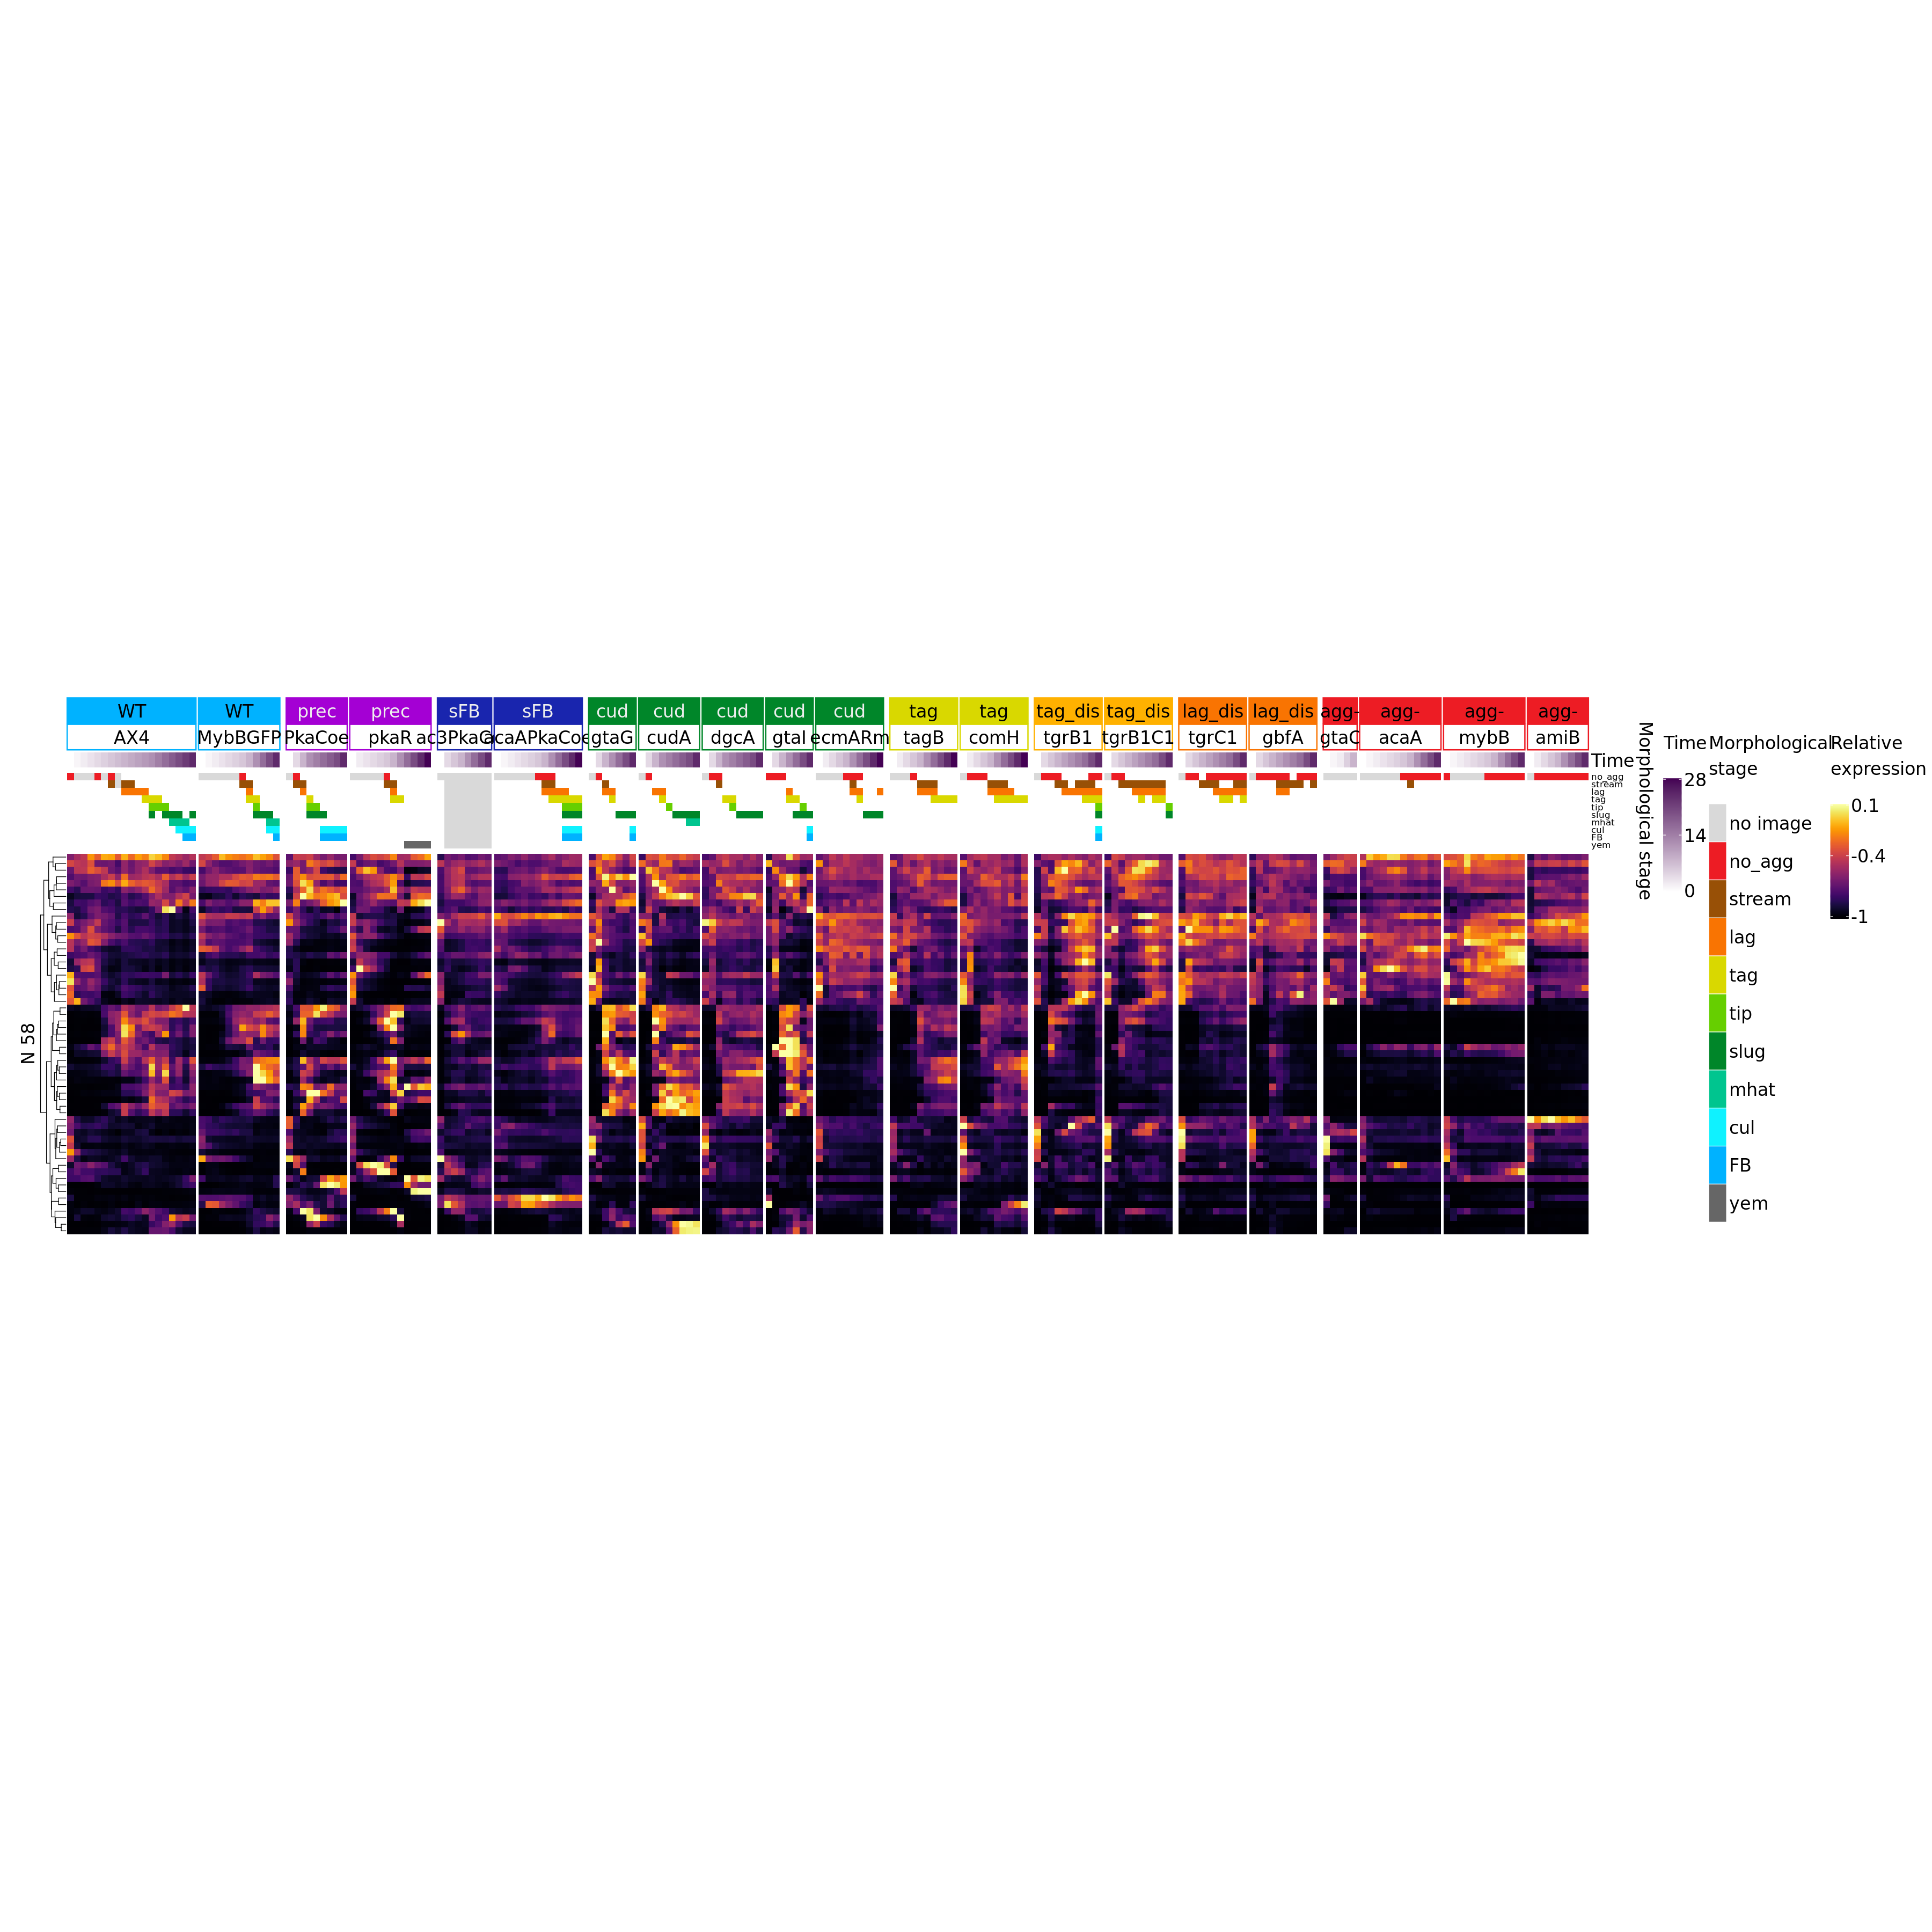

In [1956]:
options(repr.plot.width=30, repr.plot.height=30)
vecGenes<-vecPlotGenes[
    filterNLargeDiff[,'nLargeDiffRef']<filterNLargeDiff[,'nLargeDiffCase'] 
    & filterTransitions[,'hasComplexShape']]
    
    expression=t(avg_expression[avg_expression$Strain=='AX4',vecGenes])
    #expression=t(avg_expression[,genes])
    distances<-dist(expression, method="cosine")
    hc<-hclust(d=distances, method = "ward.D2" )
    hc_ordered<-reorder(x=hc,dist = distances)
    vecGenes<- as.dendrogram(hc_ordered) %>% labels
    
    n_genes=length(vecGenes)
    #print(paste(comparison,n_genes))

    data_anno=paste('N',n_genes)
    height=0.3*n_genes
    if (height>15) height=15
    heatmap=Heatmap(t(avg_expression[,vecGenes]),
                    cluster_columns = FALSE,cluster_rows = TRUE,
                    show_column_names = FALSE,
                      show_row_names = FALSE, col=inferno(256),column_title=NULL, 
                      row_title=data_anno,
                      show_heatmap_legend = TRUE,heatmap_legend_param = list(
                      title = "\nRelative \nexpression\n",
                      at = c(min_expression, round(mean(c(min_expression,max_expression)),1),max_expression),
                      grid_width= unit(legend_width, "cm"),grid_height= unit(legened_height, "cm") ,
                      labels_gp = gpar(fontsize = cluster_font),title_gp = gpar(fontsize = cluster_font)),
                      #** Cluster name fontsize
                      row_title_gp=gpar(fontsize=cluster_font),height=unit(height, "cm"))

    draw(make_anno() %v% heatmap,width=unit(60, "cm"),column_title_gp = gpar(fontsize = cluster_font))
options(repr.plot.width=5, repr.plot.height=5)

In [1958]:
write.table(data.frame(Gene=vecPlotGenes[
    filterNLargeDiff[,'nLargeDiffRef']<filterNLargeDiff[,'nLargeDiffCase'] 
    & filterTransitions[,'hasComplexShape']]),file=paste(pathSave,'try4.tsv',sep=''),sep='\t',row.names = FALSE)

In [1959]:
paste(pathSave,'try4.tsv',sep='')

[1] "/home/khrovatin/timeTrajectoriesNet/data/stages/disagg/impulse/try4.tsv"

# NOT IMPLEMENTED Gene selection based on N large differences
No models are fitted for this.
REASON: Problems with noisy local min/max for deterining large differences between more prominent min/max.

In [1738]:
genesNorm<-read.table(paste(pathConditions,'mergedGenes_RPKUM.tsv',sep=''), header=TRUE,row.names=1, sep="\t")

In [1768]:
geneData<-merge(t(genesNorm), conditions[c('Time','Strain')], by='row.names')
rownames(geneData)<-geneData$Row.names
geneData<-subset(geneData, select = -c(Row.names))
geneData<-aggregate(. ~ Strain+Time, data = geneData, median)

In [1773]:
agg<-aggregate(. ~ Strain+Time, data = geneData, median)

In [ ]:
for (gene in rownames(genesNorm)){
    dataRef<-agg[agg$Strain=='AX4',gene]
    if(any(dataRef>0)){
        rangeRef<-max(dataRef)-min(dataRef)

    }
}